In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import sklearn
import tensorflow as tf
from tensorflow import keras
from PIL import Image as im
from glob import glob
from sklearn.model_selection import train_test_split
import keras
#from tf.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Train Datasets Collection & Understanding**

In [ ]:
train_path = '/content/drive/MyDrive/Multiclassification/train'

Class to label mapping: {'glass': 0, 'metal': 1, 'organic': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


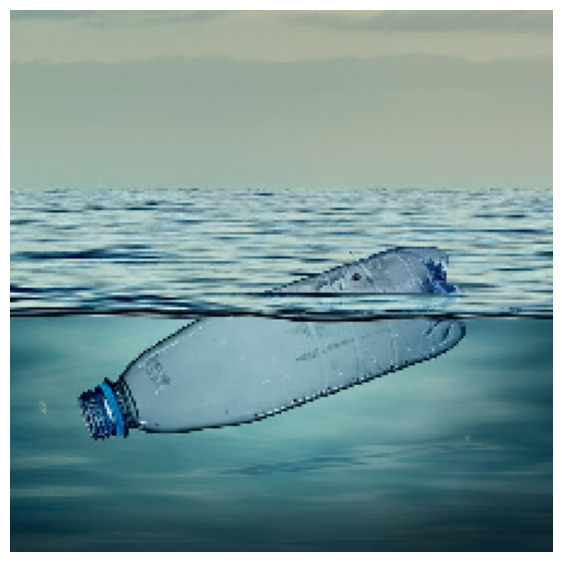

(2916, 224, 224, 3) (2916,)


In [ ]:
class_names = os.listdir(train_path)
# Create a dictionary for mapping class names to integer labels
# Sorting ensures a consistent mapping
class_to_label_dict = {name: i for i, name in enumerate(sorted(class_names))}
print(f"Class to label mapping: {class_to_label_dict}")

train_data = []
train_labels = []
for class_name in class_names:
  dir_path = os.path.join(train_path, class_name)
  for image_name in os.listdir(dir_path):
    img_path = os.path.join(dir_path, image_name)
    # Read as 3-channel image. If grayscale, cv2.imread will convert it.
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}. Skipping.")
        continue
    img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
    train_data.append(img)
    train_labels.append(class_to_label_dict[class_name])

plt.figure(figsize=(7,10))
plt.axis('off')
# Ensure img is not None before plotting and convert BGR to RGB for matplotlib
if 'img' in locals() and img is not None:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
else:
    print("No image to display (possibly due to read errors).")
plt.show() # Explicitly show the plot
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape, train_labels.shape)


## Training Datas Labels

In [ ]:
# Show the data classes
classes = os.listdir(train_path)
classes

['trash', 'glass', 'organic', 'paper', 'metal', 'plastic']

### **Test Datasets Collection & Understanding**

In [ ]:
test_path = '/content/drive/MyDrive/Multiclassification/test'

In [ ]:
#Loading train datasets
test_data = []
test_labels = []
classes = 6 #data belonges to 6 class
for i in os.listdir(test_path):
    dir = test_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if img is None:
               print("⚠️ Cannot read file:", img_path)
               continue

        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        test_data.append(img)
        test_labels.append(dict[i])


test_data = np.array(test_data)
test_labels = np.array(test_labels)
print(test_data.shape, test_labels.shape)


(837, 224, 224, 3) (837,)


### **Data Augmentation part done on training Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
training_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
training_data = training_datagen.flow_from_directory(train_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 2908 images belonging to 6 classes.


In [ ]:
# show augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### **Data Augmentation Visualization**

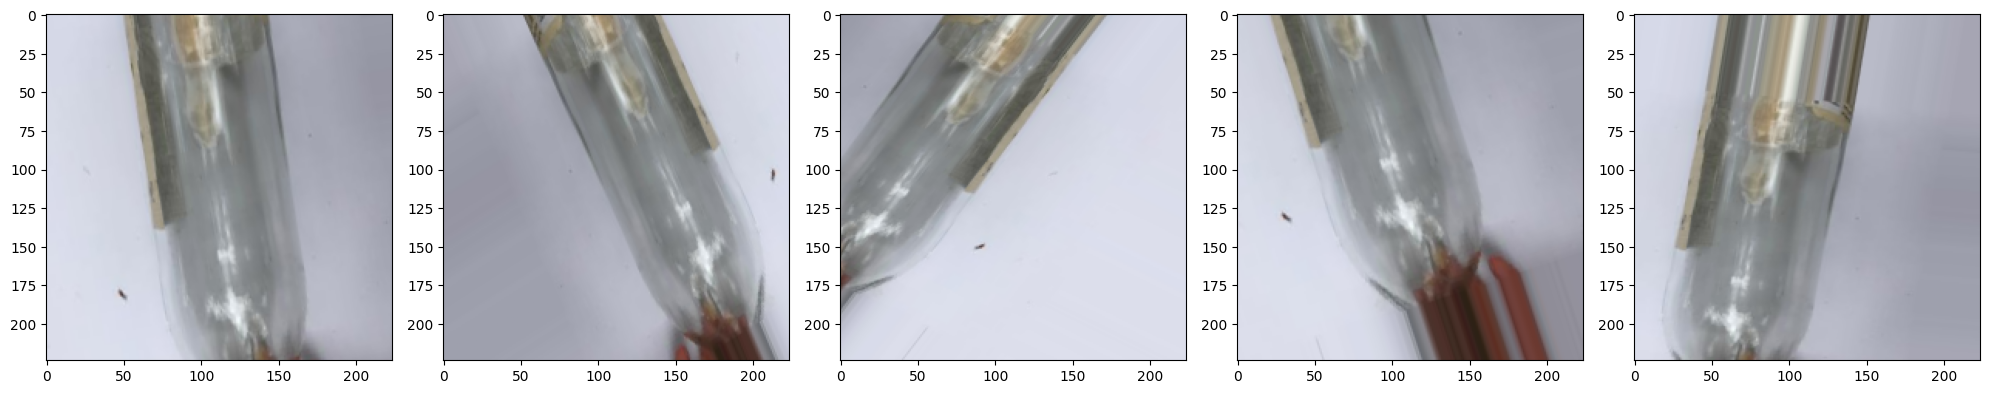

In [ ]:
# showing augmented images
images = [training_data[0][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Traingn images')

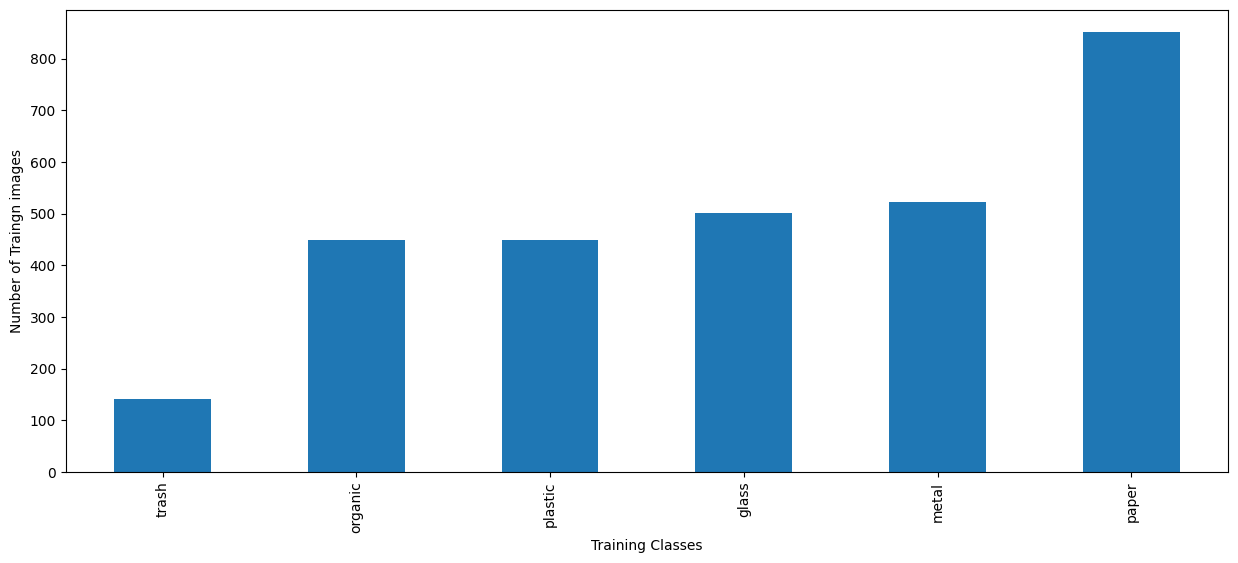

In [ ]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(train_path):
    data_dic[folder] = len(os.listdir(train_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

### **Data Augmentation part done on Testing Dataset**

In [ ]:
# this is the augmentation configuration we will use for training
# It generate more images using below parameters
testing_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# at train_data_path, and indefinitely generate
# batches of augmented image data
testing_data = testing_datagen.flow_from_directory(test_path, # this is the target directory means give train directory path
                                      target_size=(224, 224), # all images will be resized to 224x224
                                      batch_size=32,
                                      class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

Found 831 images belonging to 6 classes.


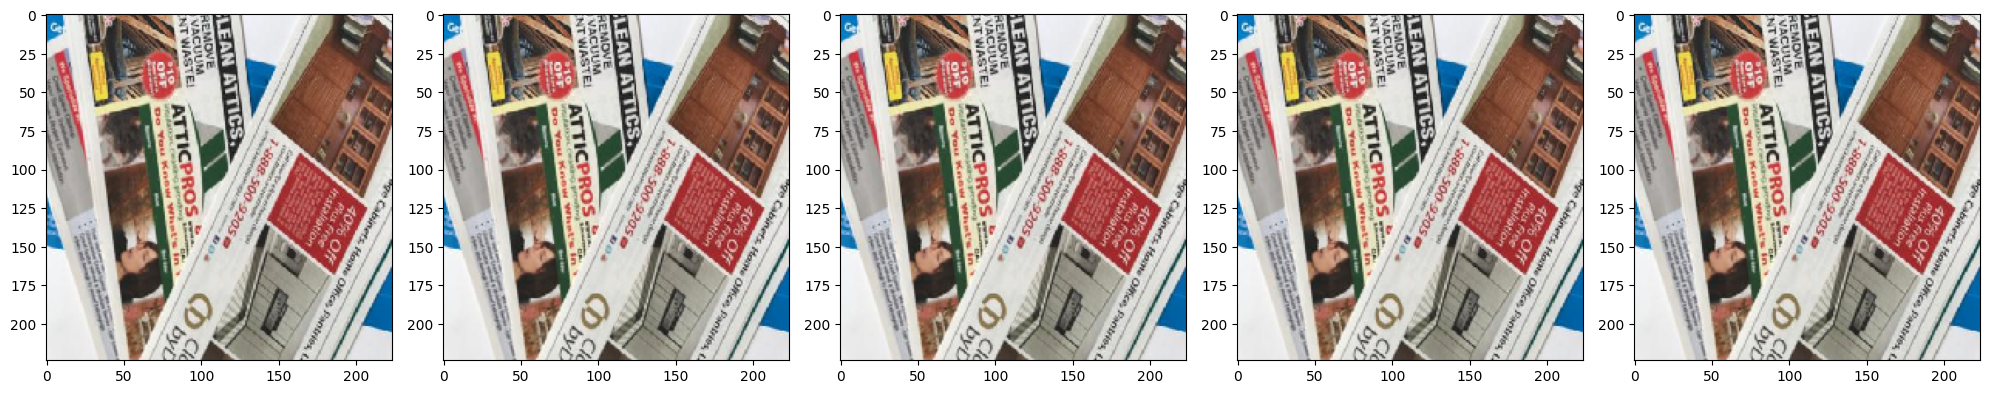

In [ ]:
# showing augmented images
images = [testing_data[1][0][0] for i in range(5)]
plotImages(images)

Text(0, 0.5, 'Number of Valedation images')

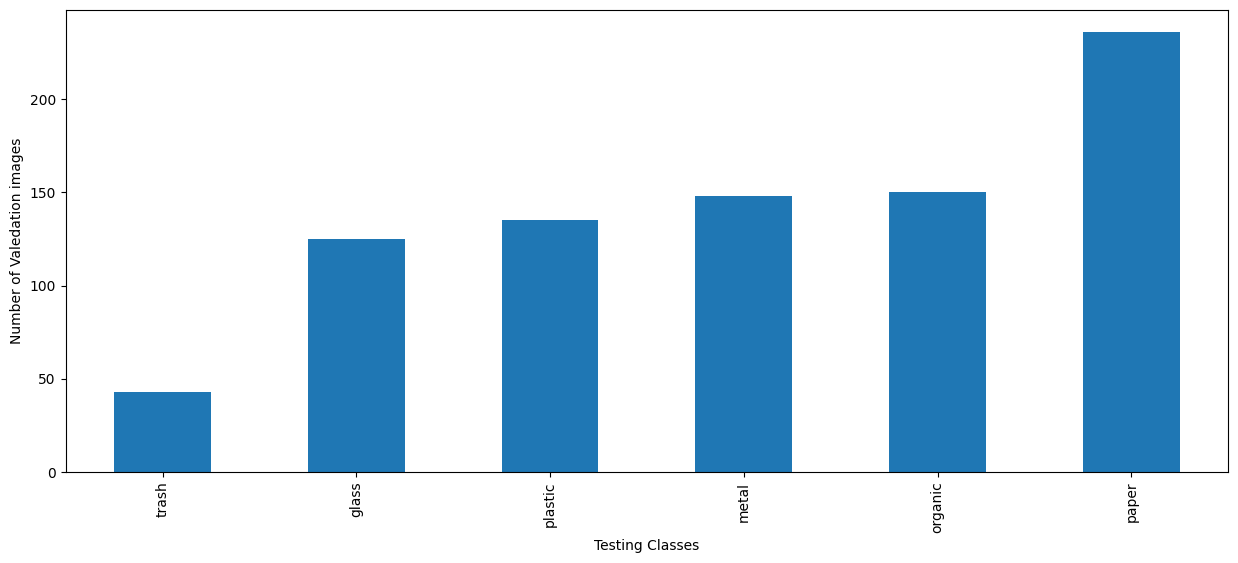

In [ ]:
# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(test_path):
    data_dic[folder] = len(os.listdir(test_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Testing Classes')
plt.ylabel('Number of Valedation images')

## **CNN - VGG16 Architeture using Tranfer Learning**

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
'''
# Import label encoder
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
'''

from tensorflow.keras.utils import to_categorical

In [ ]:
train_labels.shape

(2916,)

In [ ]:
X_train = train_data
y_train = train_labels
X_test = test_data
y_test = test_labels


Y_train = (to_categorical(y_train))
Y_test = (to_categorical(y_test))
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(2916, 224, 224, 3)
(2916, 6)
(837, 224, 224, 3)
(837, 6)


In [ ]:
# We build the base model
base_model = VGG16(input_shape=IMAGE_SIZE + [3],weights='imagenet', include_top=False)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# We freeze every layer in our base model so that they do not train, we want that our feature extractor stays as before --> transfer learning
for layer in base_model.layers:
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')


# We take the last layer of our the model and add it to our classifier
last = base_model.layers[-1].output
x = Flatten()(last)
#x = Dense(1000, activation='relu', name='fc1')(x)
#x = Dropout(0.3)(x)
prediction = Dense(len(os.listdir(train_path)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction)


Layer input_layer frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [ ]:
# We compile the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])



In [ ]:
model.summary() # Tranfer Learning Summary

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │       150,534 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,865,222 (56.71 MB)

 Trainable params: 150,534 (588.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Saves Keras model after each epoch
checkpointer = ModelCheckpoint(filepath = 'vgg16_model.weights.best.keras',
                               verbose = False,
                               save_best_only = True)

# Early stopping to prevent overtraining and to ensure decreasing validation loss
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 4,
                           restore_best_weights = True,
                           mode = 'min')

In [ ]:
result_VGG_TF = model.fit(training_data,steps_per_epoch=len(training_data),epochs=10,callbacks=[early_stop, checkpointer],validation_data=testing_data,validation_steps=len(testing_data))

'''
# We start the training
epochs = 100
batch_size = 256
# We train it
result_VGG_TF = model.fit(X_train, Y_train,
                                    batch_size=batch_size,
                                    validation_data=(X_test, Y_test),
                                    epochs = 100)
                                    '''

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 4/91 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - accuracy: 0.1960 - loss: 2.5669

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 782ms/step - accuracy: 0.4201 - loss: 1.6643 - val_accuracy: 0.7124 - val_loss: 0.8467
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 609ms/step - accuracy: 0.6718 - loss: 0.9520 - val_accuracy: 0.7232 - val_loss: 0.7899
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 609ms/step - accuracy: 0.7040 - loss: 0.8788 - val_accuracy: 0.7316 - val_loss: 0.8040
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 605ms/step - accuracy: 0.7248 - loss: 0.8007 - val_accuracy: 0.7401 - val_loss: 0.7751
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 55s 607ms/step - accuracy: 0.7208 - loss: 0.8530 - val_accuracy: 0.7533 - val_loss: 0.7396
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 56s 614ms/step - accuracy: 0.7715 - loss: 0.6667 - val_accuracy: 0.7557 - val_loss: 0.7259
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 57s 621ms/step - accuracy: 0.7631 - loss: 0.7127 - val_accuracy: 0.7401 - val_loss: 0.7382
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 57s 624ms/step - accuracy: 0.7736 - loss: 0.6675 - val_accuracy: 0.732

'\n# We start the training\nepochs = 100\nbatch_size = 256\n# We train it\nresult_VGG_TF = model.fit(X_train, Y_train,\n                                    batch_size=batch_size,\n                                    validation_data=(X_test, Y_test),\n                                    epochs = 100)\n                                    '

In [ ]:
probs = model.predict(testing_data,steps = len(testing_data), verbose = 1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step


In [ ]:
preds = np.argmax(probs,axis = 1)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report,confusion_matrix

# Use the true labels directly from the generator to match the predictions
true_labels_for_evaluation = testing_data.classes

print(classification_report(true_labels_for_evaluation,preds))
print(confusion_matrix(true_labels_for_evaluation,preds))


              precision    recall  f1-score   support

           0       0.16      0.12      0.14       122
           1       0.20      0.19      0.19       147
           2       0.18      0.22      0.20       148
           3       0.26      0.25      0.26       236
           4       0.14      0.15      0.14       135
           5       0.06      0.07      0.07        43

    accuracy                           0.19       831
   macro avg       0.17      0.17      0.17       831
weighted avg       0.19      0.19      0.19       831

[[15 25 23 33 15 11]
 [13 28 31 44 25  6]
 [15 20 32 48 26  7]
 [26 41 48 60 50 11]
 [19 22 30 33 20 11]
 [ 4  5 12 14  5  3]]


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_data.classes,preds)


cm

array([[15, 25, 23, 33, 15, 11],
       [13, 28, 31, 44, 25,  6],
       [15, 20, 32, 48, 26,  7],
       [26, 41, 48, 60, 50, 11],
       [19, 22, 30, 33, 20, 11],
       [ 4,  5, 12, 14,  5,  3]])

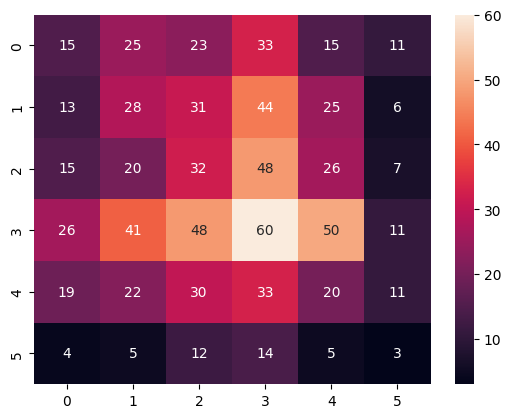

In [ ]:
import seaborn as sns
sns.heatmap(cm,annot=True)
plt.savefig('h1.png')

In [ ]:
# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(testing_data.classes,preds)
score

0.1901323706377858

In [ ]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(testing_data, steps = len(testing_data), verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

16/26 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.7436 - loss: 0.6527

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.7488 - loss: 0.6583
Test loss: 0.6746800541877747
Test accuracy: 0.7593261003494263


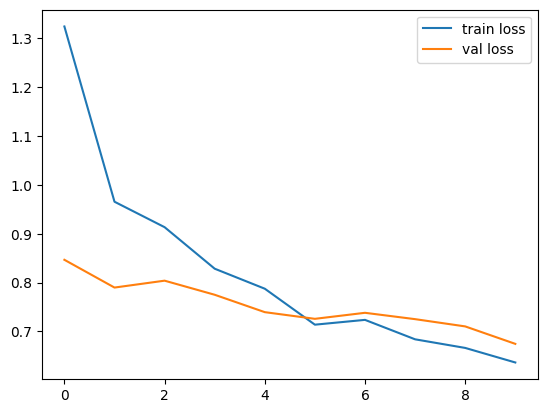

<Figure size 640x480 with 0 Axes>

In [ ]:
# loss
plt.plot(result_VGG_TF.history['loss'], label='train loss')
plt.plot(result_VGG_TF.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

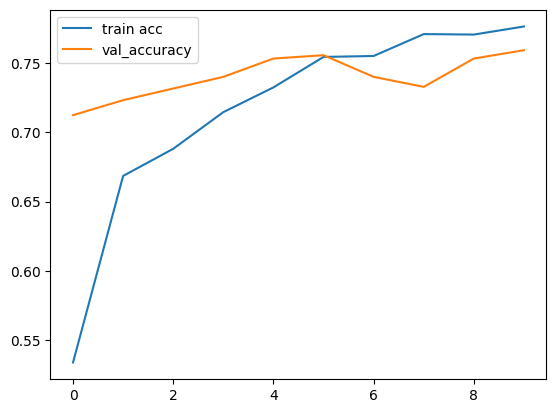

<Figure size 640x480 with 0 Axes>

In [ ]:
# accuracies
plt.plot(result_VGG_TF.history['accuracy'], label='train acc')
plt.plot(result_VGG_TF.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(testing_data)

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step


In [ ]:
y_pred

array([[9.9825943e-03, 7.8610964e-07, 2.1529360e-01, ..., 1.3166811e-01,
        4.2922878e-01, 3.0738747e-04],
       [2.5396213e-01, 6.8097506e-06, 1.7023319e-02, ..., 6.9826281e-01,
        2.9550267e-02, 1.4819769e-04],
       [1.3304777e-01, 1.1354387e-04, 1.7304474e-01, ..., 5.2477258e-01,
        7.0704311e-02, 9.6058913e-02],
       ...,
       [2.5819344e-04, 3.7606405e-05, 8.7567115e-01, ..., 3.7079537e-04,
        1.1502513e-01, 2.8335198e-03],
       [1.1134456e-02, 1.2851635e-08, 3.3694593e-04, ..., 9.8824906e-01,
        1.8585542e-04, 8.5329830e-06],
       [6.6654809e-04, 2.7706330e-03, 7.3090099e-02, ..., 3.2258590e-03,
        2.4606343e-02, 1.5509682e-02]], dtype=float32)

In [ ]:
prediction = np.argmax(y_pred,axis =1)

In [ ]:
prediction

array([4, 2, 3, 2, 3, 1, 3, 5, 3, 1, 2, 5, 3, 3, 2, 3, 4, 2, 0, 2, 4, 3,
       1, 3, 3, 3, 3, 2, 3, 5, 0, 4, 3, 1, 1, 1, 3, 2, 4, 3, 3, 3, 4, 2,
       3, 0, 5, 1, 0, 2, 4, 3, 3, 2, 3, 1, 3, 0, 3, 3, 0, 1, 3, 1, 0, 3,
       3, 4, 2, 0, 5, 3, 3, 0, 4, 3, 3, 3, 2, 0, 4, 5, 2, 3, 1, 2, 3, 1,
       1, 2, 1, 1, 4, 1, 1, 1, 4, 2, 4, 2, 0, 3, 2, 3, 3, 3, 2, 2, 2, 5,
       3, 2, 2, 4, 3, 1, 1, 5, 2, 2, 4, 2, 3, 3, 1, 0, 1, 2, 4, 2, 4, 0,
       1, 3, 3, 0, 5, 3, 1, 5, 2, 3, 1, 2, 2, 2, 3, 4, 1, 1, 1, 2, 1, 2,
       1, 3, 1, 5, 3, 4, 3, 4, 4, 4, 2, 2, 4, 1, 2, 3, 4, 2, 4, 1, 4, 5,
       1, 2, 3, 1, 3, 1, 4, 2, 1, 0, 0, 2, 5, 3, 2, 3, 0, 0, 3, 1, 1, 2,
       2, 3, 2, 2, 0, 3, 0, 3, 3, 3, 1, 4, 3, 3, 2, 0, 0, 4, 3, 1, 5, 3,
       1, 3, 3, 0, 3, 1, 3, 1, 1, 2, 0, 0, 1, 2, 4, 2, 1, 3, 3, 5, 3, 4,
       2, 1, 1, 0, 3, 4, 1, 3, 2, 2, 3, 5, 3, 3, 2, 0, 4, 2, 3, 0, 5, 0,
       1, 3, 3, 2, 1, 2, 3, 4, 3, 4, 2, 3, 3, 5, 4, 5, 3, 0, 4, 4, 2, 3,
       1, 2, 3, 3, 4, 2, 4, 2, 0, 2, 1, 5, 1, 2, 3,

In [ ]:
# Regenerate rev_dict based on the actual class_to_label_dict
# (Assuming class_to_label_dict is defined correctly in an earlier cell and reflects actual directories)
rev_dict = {v: k for k, v in class_to_label_dict.items()}



In [ ]:
rev_dict.values()

dict_values(['glass', 'metal', 'organic', 'paper', 'plastic', 'trash'])

In [ ]:
rev_dict.values()

dict_values(['glass', 'metal', 'organic', 'paper', 'plastic', 'trash'])

In [ ]:
y_hat_pred = []
for i in prediction:
  y_hat_pred.append(rev_dict[i])

In [ ]:
y_hat_pred

['plastic',
 'organic',
 'paper',
 'organic',
 'paper',
 'metal',
 'paper',
 'trash',
 'paper',
 'metal',
 'organic',
 'trash',
 'paper',
 'paper',
 'organic',
 'paper',
 'plastic',
 'organic',
 'glass',
 'organic',
 'plastic',
 'paper',
 'metal',
 'paper',
 'paper',
 'paper',
 'paper',
 'organic',
 'paper',
 'trash',
 'glass',
 'plastic',
 'paper',
 'metal',
 'metal',
 'metal',
 'paper',
 'organic',
 'plastic',
 'paper',
 'paper',
 'paper',
 'plastic',
 'organic',
 'paper',
 'glass',
 'trash',
 'metal',
 'glass',
 'organic',
 'plastic',
 'paper',
 'paper',
 'organic',
 'paper',
 'metal',
 'paper',
 'glass',
 'paper',
 'paper',
 'glass',
 'metal',
 'paper',
 'metal',
 'glass',
 'paper',
 'paper',
 'plastic',
 'organic',
 'glass',
 'trash',
 'paper',
 'paper',
 'glass',
 'plastic',
 'paper',
 'paper',
 'paper',
 'organic',
 'glass',
 'plastic',
 'trash',
 'organic',
 'paper',
 'metal',
 'organic',
 'paper',
 'metal',
 'metal',
 'organic',
 'metal',
 'metal',
 'plastic',
 'metal',
 'meta